This notebook is JUST for experimental constraints bar graphs/tables (uses the BIG dataframe). All other anlaysis goes in the main notebook

In [1]:
from copy import deepcopy
from contextlib import contextmanager

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm, Normalize
import matplotlib.gridspec as gridspec
from itertools import izip
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MultipleLocator
from collections import namedtuple
from IPython.display import IFrame
import functools

%matplotlib inline

get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')


mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (7.0, 4.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.numpoints'] = 1
# mpl.rcParams.update({'font.size': 24, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams.update({'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [53]:
from common_plots import *

In [3]:
from common_strings import *

In [4]:
# Make subsets based on masses, and passing ALL NMSSMTools constraints (i.e. don't ignore g-2 and relic density)
from make_hdf5 import subset_var

In [10]:
# Here get your dataframes.
# Extract dataframes from binary
store = pd.HDFStore("points_500_MICRO_SCAN_NTv493_HBv431_HSv140_smallMa1_DMass2_fixAssignMass_07_Jul_16_1542.h5")
df_orig_1 = store.full12loop_all
# df_pass_all_1 = store.full12loop_good_posMuMagMom_planckUpperOnly_ignorebctaunu_ignorechi2 #'relaxed' constraints - +ve g-2 and omegah^2

store.close()

/Users/robina/.virtualenvs/NMSSMScan/lib/python2.7/site-packages/tables/leaf.py:386: PerformanceWarning: The Leaf ``/full12loop_all/_i_table/constraints/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [ ]:
# Here get your dataframes.
# Extract dataframes from binary
store = pd.HDFStore("points_500_MICRO_SCAN_NTv493_HBv431_HSv140_smallMa1_DMass2_fixAssignMass_09_Jul_16_0907.h5")
df_orig_2 = store.full12loop_all
# df_pass_all_2 = store.full12loop_good_posMuMagMom_planckUpperOnly_ignorebctaunu_ignorechi2 #'relaxed' constraints - +ve g-2 and omegah^2

store.close()

In [ ]:
df_orig = pd.concat([df_orig_1, df_orig_2])

Helper functions for saving plots with different backends easily:

In [8]:
def get_backend():
    return list(get_ipython().magic(u"config InlineBackend.figure_formats"))

def set_backend(fmt):
    print 'Setting backend', fmt
    get_ipython().magic(u"config InlineBackend.figure_formats = '%s', " % fmt)

@contextmanager
def backend(fmt):
    old_fmt = get_backend()[0]
    set_backend(fmt)
    yield
#     set_backend(old_fmt)
    set_backend('png')

def save_fig(func):
    """Decorator func for easily saving plots in jupyter notebook.
    
    Just add in a filename=XXX to your normal function arguments.
    It will auto switch backends correctly.
    """
    def wrapper(*args, **kwargs):
        filename = kwargs['filename']
        if filename == '':
            raise IOError('No filename')
        if '.' not in filename:
            raise IOError('No extension in filename: %s' % filename)
        fmt = os.path.splitext(filename)[1].lstrip('.') if SAVE_PLOTS else 'png'
        with backend(fmt):
            new_kwargs = deepcopy(kwargs)
            del new_kwargs['filename']
            func(*args, **new_kwargs)
            if SAVE_PLOTS: 
                save_plot(filename)
    return wrapper


In [9]:
SAVE_PLOTS = True

if SAVE_PLOTS:
    set_backend('png')
    mpl.rcParams['savefig.dpi'] = 100
else:
    set_backend('png')
    mpl.rcParams['savefig.dpi'] = 72

Setting backend png


# Optional constraint flags

In [30]:

def add_constraint_flags(df):
    accept_constraints = {
            "pass_del_a_mu": r"Muon magn\. mom\. more than 2 sigma away",
            "pass_relic_small": r"Relic density too small \(Planck\)",
            "pass_relic_large": r"Relic density too large \(Planck\)",
            "pass_bctaunu": r"b \-> c tau nu more than 2 sigma away \(as SM\)",
            "pass_chi2zz": r"chi2\(H\->ZZ\) > 6\.18",
            "pass_chi2bb": r"chi2\(H\->bb\) > 6\.18",
            "pass_chi2gg": r"chi2\(H\->gg\) > 6\.18",
            "pass_cms4mu": r"Excluded H_125\->AA\->4mu \(CMS\)",
            "pass_h125": r"No Higgs in the 122.1-128.1 GeV mass range"
    }

    for k, v in accept_constraints.iteritems():
        if k not in df.columns:
            df[k] = ~df.constraints.str.contains(v)

    df['pass_HSHB'] = (df.HSprob > 0.05) & (df.HBresult==1)
    df['pass_NT'] = (df.pass_chi2zz) & (df.pass_chi2bb) & (df.pass_chi2gg)
    df['pass_strict'] = (df.pass_HSHB) & (df.pass_NT) & (df.pass_del_a_mu) & (df.pass_relic_small)

In [31]:
add_constraint_flags(df_orig_1)

# Why are there few points 4 < ma1 < 6 GeV

In [77]:
def plot_ma1_constraints(mass_low, mass_high, n=15):
    q_str = '%f<ma1<%f & pass_h125 & Del_a_mu>0 & pass_relic_large' % (mass_low, mass_high)
    title_str = r'$%g\ <\ m_{a_1} <\ %g\ \mathrm{GeV}$' % (mass_low, mass_high)
    return plot_constraints(df_orig_1.query(q_str), title_str, num=15)

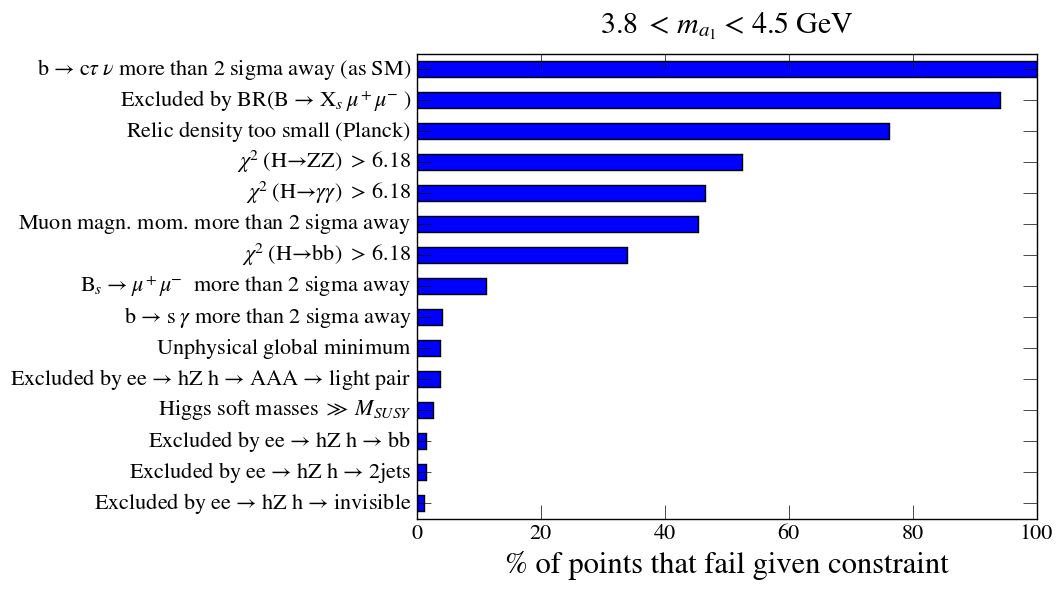

In [112]:
ax, vc_3p8 = plot_ma1_constraints(3.8, 4.5)

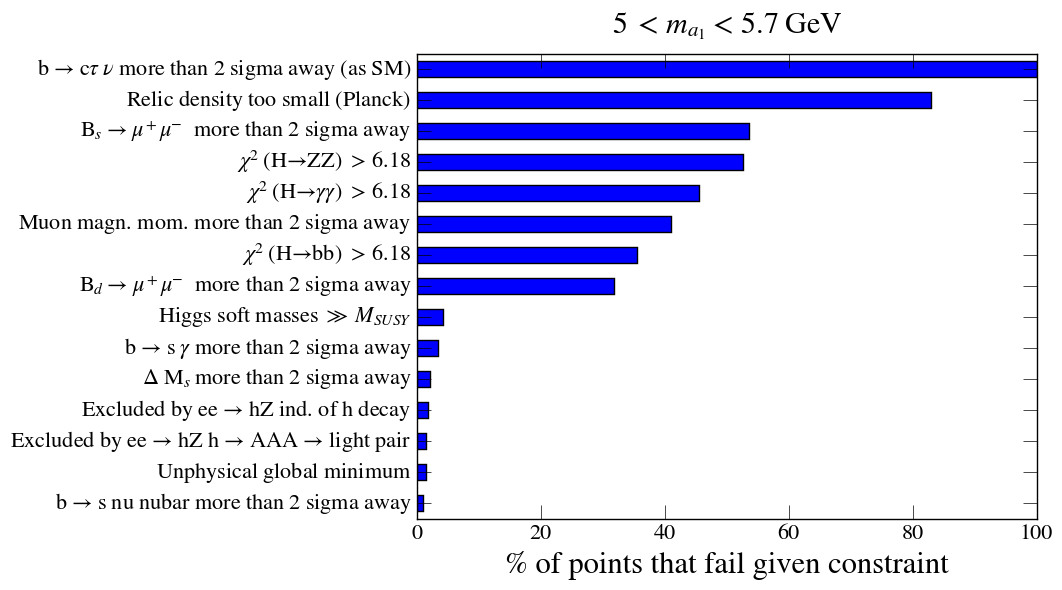

In [113]:
ax, vc_5 = plot_ma1_constraints(5, 5.7)

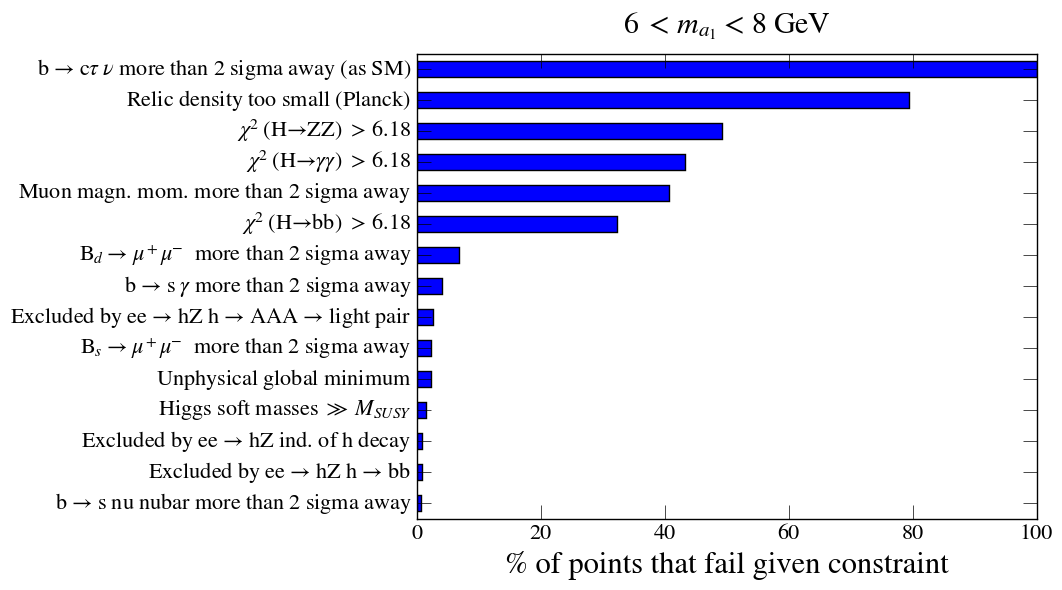

In [114]:
ax, vc_side = plot_ma1_constraints(6, 8)

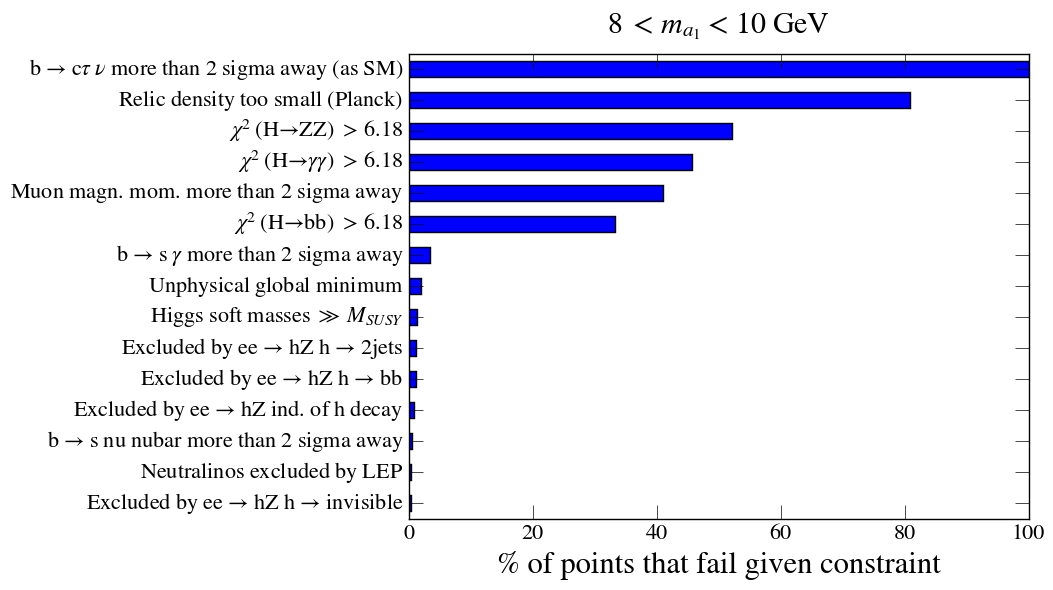

In [99]:
ax, vc_8 = plot_ma1_constraints(8, 10, n=20)

In [101]:
df_orig_1[df_orig_1.constraints.str.contains('Upsilon')].head()

,Bra1bb,Bra1cc,Bra1gg,Bra1mumu,Bra1ss,Bra1tautau,Brh1a1a1,Brh1a1z,Brh1bb,Brh1cc,Brh1gammagamma,Brh1gg,Brh1mumu,Brh1tautau,Brh1ww,Brh1zgamma,Brh1zz,Brh2a1a1,Brh2a1z,Brh2bb,Brh2gammagamma,Brh2gg,Brh2h1h1,Brh2tautau,Brh2ww,Brh2zgamma,Brh2zz,Del_a_mu,HBchannel,HBobsratio,HBresult,HS_10_chi2,HS_10_muPred,HS_11_chi2,HS_11_muPred,HS_12_chi2,HS_12_muPred,HS_13_chi2,HS_13_muPred,HS_14_chi2,HS_14_muPred,HS_15_chi2,HS_15_muPred,HS_16_chi2,HS_16_muPred,HS_17_chi2,HS_17_muPred,HS_18_chi2,HS_18_muPred,HS_19_chi2,HS_19_muPred,HS_1_chi2,HS_1_muPred,HS_20_chi2,HS_20_muPred,HS_21_chi2,HS_21_muPred,HS_22_chi2,HS_22_muPred,HS_23_chi2,HS_23_muPred,HS_24_chi2,HS_24_muPred,HS_25_chi2,HS_25_muPred,HS_26_chi2,HS_26_muPred,HS_27_chi2,HS_27_muPred,HS_28_chi2,HS_28_muPred,HS_29_chi2,HS_29_muPred,HS_2_chi2,HS_2_muPred,HS_30_chi2,HS_30_muPred,HS_31_chi2,HS_31_muPred,HS_32_chi2,HS_32_muPred,HS_33_chi2,HS_33_muPred,HS_34_chi2,HS_34_muPred,HS_35_chi2,HS_35_muPred,HS_36_chi2,HS_36_muPred,HS_37_chi2,HS_37_muPred,HS_38_chi2,HS_38_muPred,HS_39_chi2,HS_39_muPred,HS_3_chi2,HS_3_muPred,HS_40_chi2,HS_40_muPred,HS_41_chi2,...,xsec_ggf8_h1,xsec_ggf8_h2,xsec_ggf8_h3,xsec_vbf8_h1,xsec_vbf8_h2,xsec_vbf8_h3,xsec_scaled_ggf_h1_2a1_4b,xsec_13_ggf_h1_2a1_4b,xsec_8_ggf_h1_2a1_4b,xsec_scaled_ggf_h1_2a1_2b2tau,xsec_13_ggf_h1_2a1_2b2tau,xsec_8_ggf_h1_2a1_2b2tau,xsec_scaled_ggf_h1_2a1_2b2mu,xsec_13_ggf_h1_2a1_2b2mu,xsec_8_ggf_h1_2a1_2b2mu,xsec_scaled_ggf_h1_2a1_2tau2b,xsec_13_ggf_h1_2a1_2tau2b,xsec_8_ggf_h1_2a1_2tau2b,xsec_scaled_ggf_h1_2a1_4tau,xsec_13_ggf_h1_2a1_4tau,xsec_8_ggf_h1_2a1_4tau,xsec_scaled_ggf_h1_2a1_2tau2mu,xsec_13_ggf_h1_2a1_2tau2mu,xsec_8_ggf_h1_2a1_2tau2mu,xsec_scaled_ggf_h1_2a1_2mu2b,xsec_13_ggf_h1_2a1_2mu2b,xsec_8_ggf_h1_2a1_2mu2b,xsec_scaled_ggf_h1_2a1_2mu2tau,xsec_13_ggf_h1_2a1_2mu2tau,xsec_8_ggf_h1_2a1_2mu2tau,xsec_scaled_ggf_h1_2a1_4mu,xsec_13_ggf_h1_2a1_4mu,xsec_8_ggf_h1_2a1_4mu,xsec_scaled_ggf_h2_2a1_4b,xsec_13_ggf_h2_2a1_4b,xsec_8_ggf_h2_2a1_4b,xsec_scaled_ggf_h2_2a1_2b2tau,xsec_13_ggf_h2_2a1_2b2tau,xsec_8_ggf_h2_2a1_2b2tau,xsec_scaled_ggf_h2_2a1_2b2mu,xsec_13_ggf_h2_2a1_2b2mu,xsec_8_ggf_h2_2a1_2b2mu,xsec_scaled_ggf_h2_2a1_2tau2b,xsec_13_ggf_h2_2a1_2tau2b,xsec_8_ggf_h2_2a1_2tau2b,xsec_scaled_ggf_h2_2a1_4tau,xsec_13_ggf_h2_2a1_4tau,xsec_8_ggf_h2_2a1_4tau,xsec_scaled_ggf_h2_2a1_2tau2mu,xsec_13_ggf_h2_2a1_2tau2mu,xsec_8_ggf_h2_2a1_2tau2mu,xsec_scaled_ggf_h2_2a1_2mu2b,xsec_13_ggf_h2_2a1_2mu2b,xsec_8_ggf_h2_2a1_2mu2b,xsec_scaled_ggf_h2_2a1_2mu2tau,xsec_13_ggf_h2_2a1_2mu2tau,xsec_8_ggf_h2_2a1_2mu2tau,xsec_scaled_ggf_h2_2a1_4mu,xsec_13_ggf_h2_2a1_4mu,xsec_8_ggf_h2_2a1_4mu,xsec_scaled_ggf_h2_2h1_4b,xsec_13_ggf_h2_2h1_4b,xsec_8_ggf_h2_2h1_4b,xsec_scaled_ggf_h2_2h1_2b2tau,xsec_13_ggf_h2_2h1_2b2tau,xsec_8_ggf_h2_2h1_2b2tau,xsec_scaled_ggf_h2_2h1_2b2mu,xsec_13_ggf_h2_2h1_2b2mu,xsec_8_ggf_h2_2h1_2b2mu,xsec_scaled_ggf_h2_2h1_2tau2b,xsec_13_ggf_h2_2h1_2tau2b,xsec_8_ggf_h2_2h1_2tau2b,xsec_scaled_ggf_h2_2h1_4tau,xsec_13_ggf_h2_2h1_4tau,xsec_8_ggf_h2_2h1_4tau,xsec_scaled_ggf_h2_2h1_2tau2mu,xsec_13_ggf_h2_2h1_2tau2mu,xsec_8_ggf_h2_2h1_2tau2mu,xsec_scaled_ggf_h2_2h1_2mu2b,xsec_13_ggf_h2_2h1_2mu2b,xsec_8_ggf_h2_2h1_2mu2b,xsec_scaled_ggf_h2_2h1_2mu2tau,xsec_13_ggf_h2_2h1_2mu2tau,xsec_8_ggf_h2_2h1_2mu2tau,xsec_scaled_ggf_h2_2h1_4mu,xsec_13_ggf_h2_2h1_4mu,xsec_8_ggf_h2_2h1_4mu,pass_del_a_mu,pass_bctaunu,pass_relic,pass_chi2bb,pass_chi2zz,pass_chi2gg,pass_cms4mu,pass_HSHB,pass_NT,pass_strict,pass_h125,pass_relic_small,pass_relic_large


(<matplotlib.axes._subplots.AxesSubplot at 0x1a051bed0>,
 array([   5.,    4.,    4.,   15.,   13.,   15.,   14.,   37.,   29.,
          41.,   35.,   38.,   54.,   52.,   59.,   66.,   60.,   59.,
          84.,   69.,   58.,  102.,   83.,   77.,  105.,  101.,   95.,
          91.,   77.,   91.,  129.,  125.,  108.,  137.,  133.,  133.,
         137.,  148.,  116.,  159.,  151.,  159.,  130.,  140.,  148.,
         184.,  167.,  173.,  159.,  174.]),
 array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
          1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
          3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
          5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
          7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
          9. ,   9.2,   9.4,   9.6,   9.8,  10. ]),
 <a list of 50 Patch objects>)

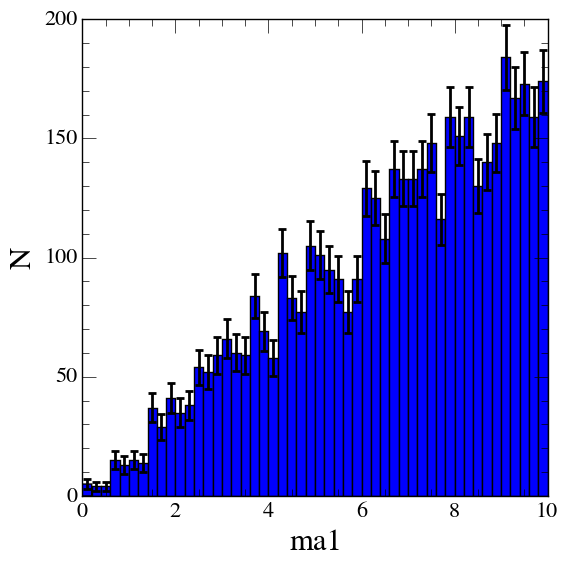

In [115]:
plot_histogram(df=df_orig_1.query('ma1<10 & pass_h125 & Del_a_mu>0 & pass_relic_large'), 
               var='ma1', bins=50, range=[0, 10])

In [119]:
col_names = ['3.8-4.5', '5-5.7', '6-8']
df_compare_fail = pd.concat({col_names[0]: vc_3p8, col_names[1]: vc_5, col_names[2]: vc_side}, axis=1).fillna(0)
df_compare_fail['Difference (3.8-4.5)'] = df_compare_fail[col_names[0]] - df_compare_fail[col_names[2]]
df_compare_fail['Difference (5-5.7)'] = df_compare_fail[col_names[1]] - df_compare_fail[col_names[2]]

In [120]:
df_compare_fail.sort_values('Difference (3.8-4.5)', ascending=False)

,3.8-4.5,5-5.7,6-8,Difference (3.8-4.5),Difference (5-5.7)
$\mathrm{Excluded\ by\ BR(B\ }\to\mathrm{\ X}_{s}\mathrm{\ }\mu^+\mu^-\mathrm{)}$,94.052045,0.305810,0.000000,94.052045,0.305810
$\mathrm{B}_{s}\mathrm{\ }\to\mathrm{\ }\mu^+\mu^-\mathrm{\ more\ than\ 2\ sigma\ away}$,11.152416,53.516820,2.339623,8.812794,51.177197
$\mathrm{Muon\ magn.\ mom.\ more\ than\ 2\ sigma\ away}$,45.353160,40.978593,40.603774,4.749386,0.374820
$\mathrm{}\chi^2\mathrm{(H}\to\gamma\gamma\mathrm{)\ >\ 6.18}$,46.468401,45.565749,43.320755,3.147647,2.244995
$\mathrm{}\chi^2\mathrm{(H}\to\mathrm{ZZ)\ >\ 6.18}$,52.416357,52.599388,49.283019,3.133338,3.316370
$\mathrm{}\chi^2\mathrm{(H}\to\mathrm{bb)\ >\ 6.18}$,33.828996,35.474006,32.226415,1.602581,3.247591
$\mathrm{Unphysical\ global\ minimum}$,3.717472,1.529052,2.264151,1.453321,-0.735099
$\mathrm{Higgs\ soft\ masses\ }\gg\mathrm{\ }M_{SUSY}\mathrm{}$,2.602230,4.281346,1.509434,1.092797,2.771912
$\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ AAA\ }\to\mathrm{\ light\ pair}$,3.717472,1.529052,2.641509,1.075963,-1.112457
$\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ 2jets}$,1.486989,0.917431,0.528302,0.958687,0.389129


In [121]:
df_compare_fail.sort_values('Difference (5-5.7)', ascending=False)

,3.8-4.5,5-5.7,6-8,Difference (3.8-4.5),Difference (5-5.7)
$\mathrm{B}_{s}\mathrm{\ }\to\mathrm{\ }\mu^+\mu^-\mathrm{\ more\ than\ 2\ sigma\ away}$,11.152416,53.516820,2.339623,8.812794,51.177197
$\mathrm{B}_{d}\mathrm{\ }\to\mathrm{\ }\mu^+\mu^-\mathrm{\ more\ than\ 2\ sigma\ away}$,0.000000,31.804281,6.716981,-6.716981,25.087300
$\mathrm{Relic\ density\ too\ small\ (Planck)}$,76.208178,82.874618,79.396226,-3.188048,3.478391
$\mathrm{}\chi^2\mathrm{(H}\to\mathrm{ZZ)\ >\ 6.18}$,52.416357,52.599388,49.283019,3.133338,3.316370
$\mathrm{}\chi^2\mathrm{(H}\to\mathrm{bb)\ >\ 6.18}$,33.828996,35.474006,32.226415,1.602581,3.247591
$\mathrm{Higgs\ soft\ masses\ }\gg\mathrm{\ }M_{SUSY}\mathrm{}$,2.602230,4.281346,1.509434,1.092797,2.771912
$\mathrm{}\chi^2\mathrm{(H}\to\gamma\gamma\mathrm{)\ >\ 6.18}$,46.468401,45.565749,43.320755,3.147647,2.244995
$\mathrm{}\Delta\mathrm{\ M}_{s}\mathrm{\ more\ than\ 2\ sigma\ away}$,0.000000,2.140673,0.000000,0.000000,2.140673
$\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ ind.\ of\ h\ decay}$,0.743494,1.834862,0.830189,-0.086694,1.004674
$\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ 2jets}$,1.486989,0.917431,0.528302,0.958687,0.389129


# Why no a1 < 2.5 GeV? 

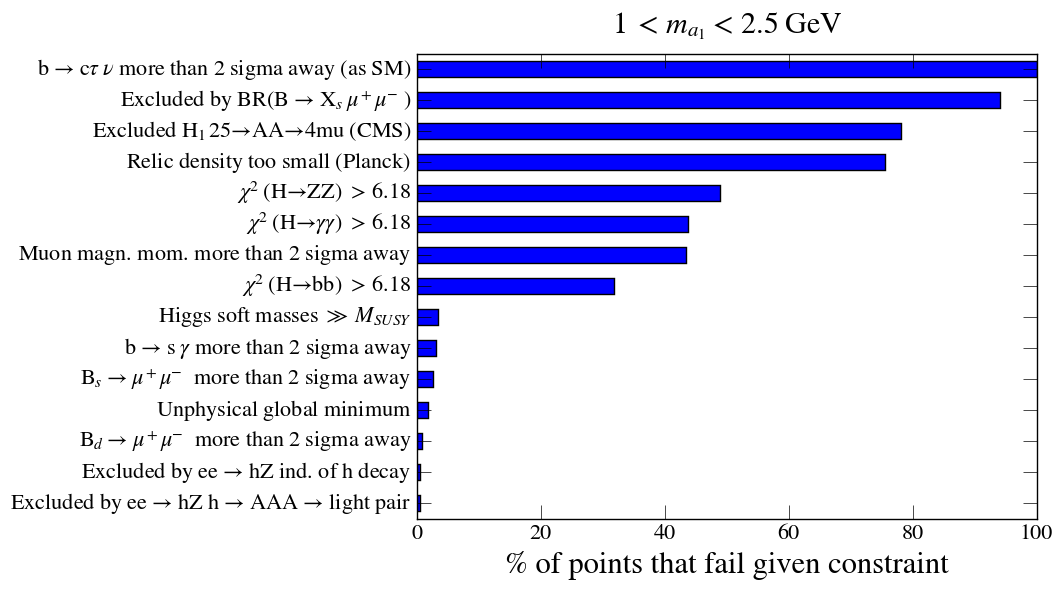

In [83]:
ax, vc_lt2p5 = plot_ma1_constraints(1, 2.5)

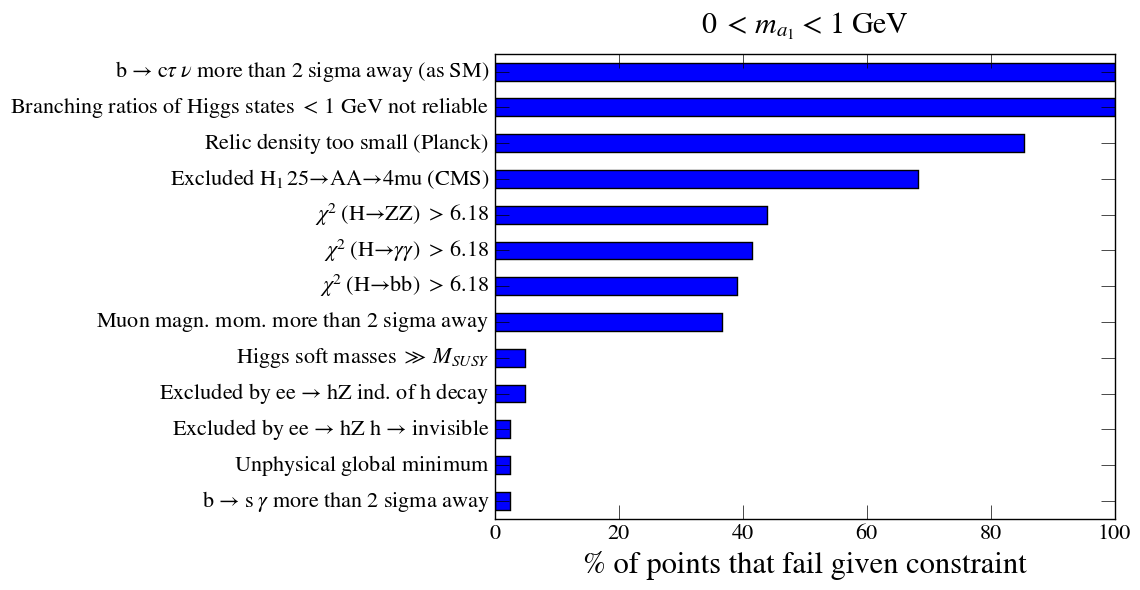

In [84]:
ax, vc_lt2p5 = plot_ma1_constraints(0, 1)

# Why a1 -> tautau ~ 0.8 - 0.9?

(<matplotlib.axes._subplots.AxesSubplot at 0x1a074acd0>,
 array([  2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   5.00000000e+00,
          2.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   5.00000000e+00,   4.16000000e+02,
          3.92000000e+02,   5.70000000e+01,   8.40000000e+01,
          1.31000000e+02,   2.05000000e+02,   3.62000000e+02,
          5.9

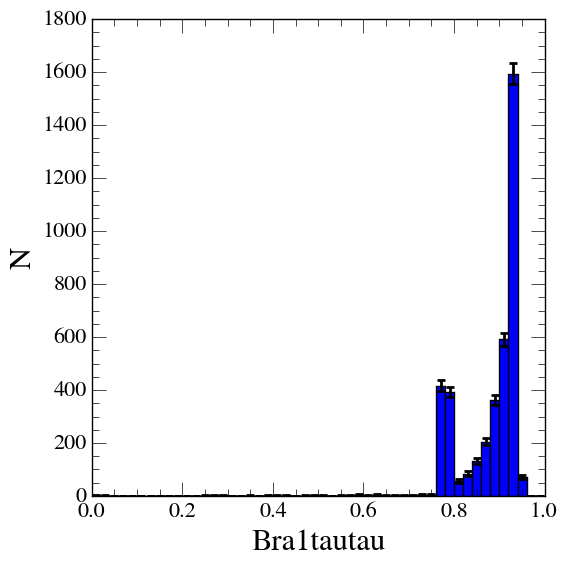

In [125]:
_ = plot_histogram(df=df_orig_1.query('ma1<10 & pass_h125 & Del_a_mu>0 & pass_relic_large'),
                   var='Bra1tautau', bins=50, range=[0,1])

In [130]:
def plot_bra1_ma1(df, title):
    fig, ax = generate_fig_axes()
    SIZE=20
    plot_scatter(ax = ax, df=df, xvar='ma1', yvar='Bra1tautau', color='green', label=r'$\tau\tau$', s=SIZE)
    plot_scatter(ax=plt.gca(), df=df, xvar='ma1', yvar='Bra1mumu', color='red', label=r'$\mu\mu$', s=SIZE)
    plot_scatter(ax=plt.gca(), df=df, xvar='ma1', yvar='Bra1bb', color='blue', label=r'$b\bar{b}$', s=SIZE)
    plot_scatter(ax=plt.gca(), df=df, xvar='ma1', yvar='Bra1cc', color='orange', label=r'$c\bar{c}$', s=SIZE)
    plot_scatter(ax=plt.gca(), df=df, xvar='ma1', yvar='Bra1ss', color='fuchsia', label=r'$s\bar{s}$', s=SIZE)
    plot_scatter(ax=plt.gca(), df=df, xvar='ma1', yvar='Bra1gg', color='purple', label=r'$gg$', s=SIZE)
    plt.xlim(0, 25)
    plt.ylim(1E-3, 1.2)
    plt.yscale('log')
    plt.legend(loc='lower right', fontsize=16, framealpha=0.85)
    plt.xlabel(r'$m_{a_1}\ \mathrm{[GeV]}$')
    plt.ylabel(r'$BR(a_1 \to XX)$')
    plt.tight_layout()

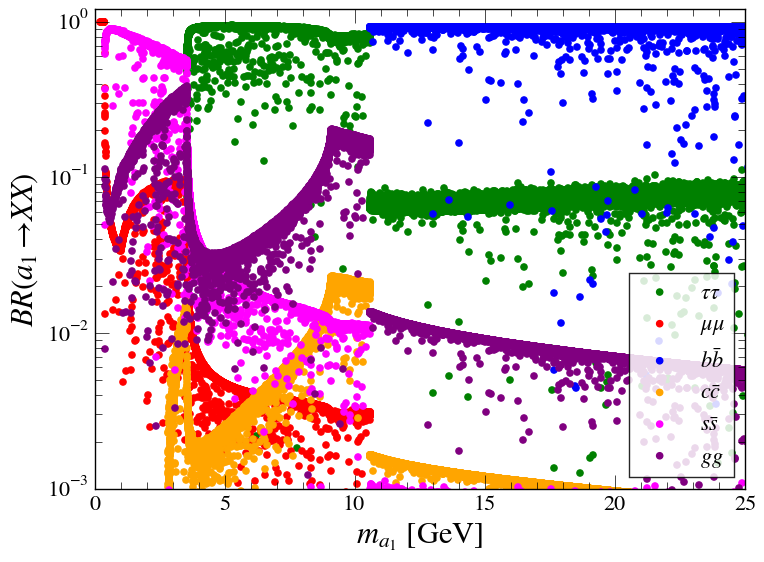

In [155]:
plot_bra1_ma1(df_orig_1, '')

# Low mass h1

(<matplotlib.axes._subplots.AxesSubplot at 0x1a1ede2d0>,
 $\mathrm{b\ }\to\mathrm{\ c}\tau\ \nu\mathrm{\ more\ than\ 2\ sigma\ away\ (as\ SM)}$             100.000000
 $\mathrm{Relic\ density\ too\ large\ (Planck)}$                                                    88.944535
 $\mathrm{Muon\ magn.\ mom.\ more\ than\ 2\ sigma\ away}$                                           60.575708
 $\mathrm{}\chi^2\mathrm{(H}\to\mathrm{ZZ)\ >\ 6.18}$                                               48.284578
 $\mathrm{}\chi^2\mathrm{(H}\to\gamma\gamma\mathrm{)\ >\ 6.18}$                                     41.273110
 $\mathrm{}\chi^2\mathrm{(H}\to\mathrm{bb)\ >\ 6.18}$                                               26.047274
 $\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ bb}$                                 13.550199
 $\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ 2jets}$                              13.175755
 $\mathrm{Relic\ density\ too\ small\ (Planck)}$               

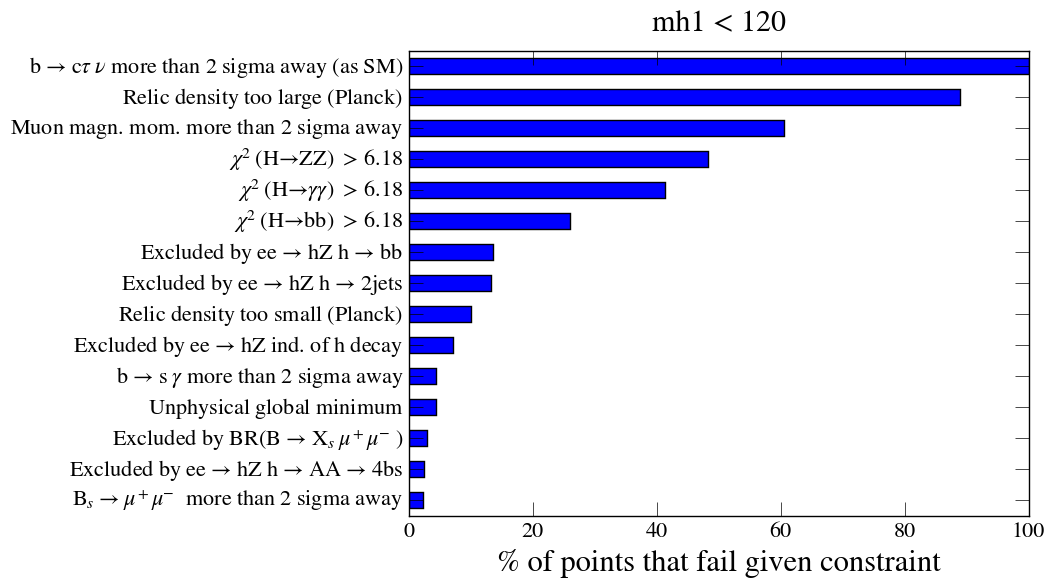

In [157]:
plot_constraints(df_orig_1.query('mh1<120 & pass_h125'), 'mh1 < 120', num=15)

(<matplotlib.axes._subplots.AxesSubplot at 0x1adc9e510>,
 $\mathrm{b\ }\to\mathrm{\ c}\tau\ \nu\mathrm{\ more\ than\ 2\ sigma\ away\ (as\ SM)}$             100.000000
 $\mathrm{Relic\ density\ too\ large\ (Planck)}$                                                    84.220820
 $\mathrm{Muon\ magn.\ mom.\ more\ than\ 2\ sigma\ away}$                                           60.494266
 $\mathrm{}\chi^2\mathrm{(H}\to\mathrm{ZZ)\ >\ 6.18}$                                               55.764957
 $\mathrm{}\chi^2\mathrm{(H}\to\gamma\gamma\mathrm{)\ >\ 6.18}$                                     48.608765
 $\mathrm{}\chi^2\mathrm{(H}\to\mathrm{bb)\ >\ 6.18}$                                               33.549649
 $\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ 2jets}$                              22.882034
 $\mathrm{Excluded\ by\ ee\ }\to\mathrm{\ hZ\ h\ }\to\mathrm{\ bb}$                                 20.428483
 $\mathrm{Relic\ density\ too\ small\ (Planck)}$               

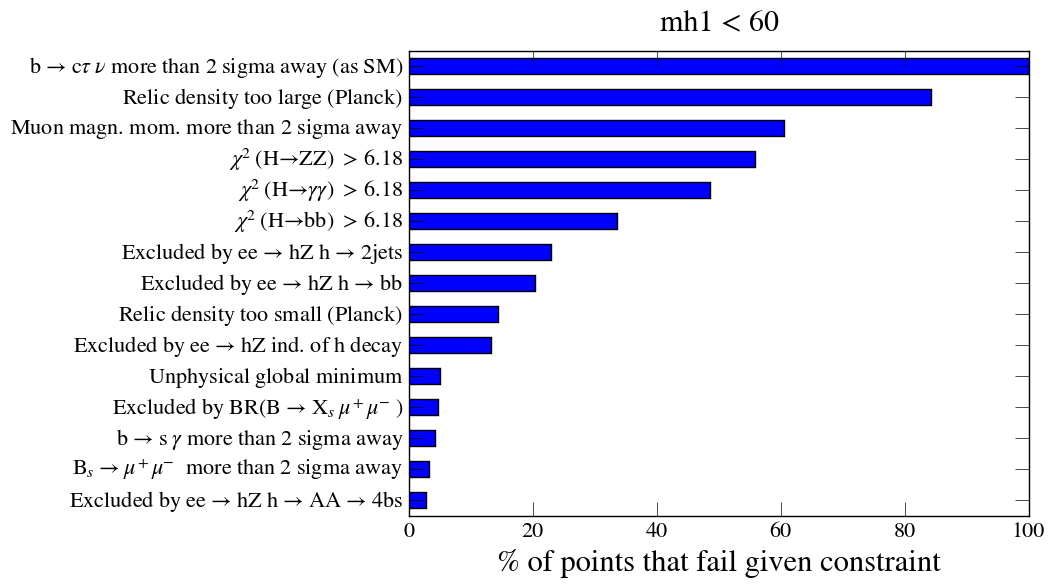

In [186]:
plot_constraints(df_orig_1.query('mh1<60 & pass_h125'), 'mh1 < 60', num=15)

(<matplotlib.axes._subplots.AxesSubplot at 0x197f0ee90>,
 array([     0.,      0.,      0.,      0.,      0.,     40.,    366.,
          1033.,   2063.,   3288.,   4778.,   6279.,   7906.,   9136.,
         10552.,  11910.,  13280.,  14418.,  15356.,  16577.,  17785.,
         18915.,  20224.,  21176.,  22224.,  23295.,  24013.,  24711.,
         25125.,  25412.,  24881.,  23853.,  22880.,  21266.,  20247.,
         18990.,  17398.,  16230.,  15051.,  13481.,  11895.,  10489.,
          9200.,   7796.,   6544.,   5256.,   4181.,   3090.,   2222.,
          1587.]),
 array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
         1600.,  1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,
         2400.,  2500.,  2600.,  2700.,  2800.,  2900.,  3000.,  3100.,
         3200.,  3300.,  3400.,  3500.,  3600.,  3700.,  3800.,  3900.,
         4000.,  4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  47

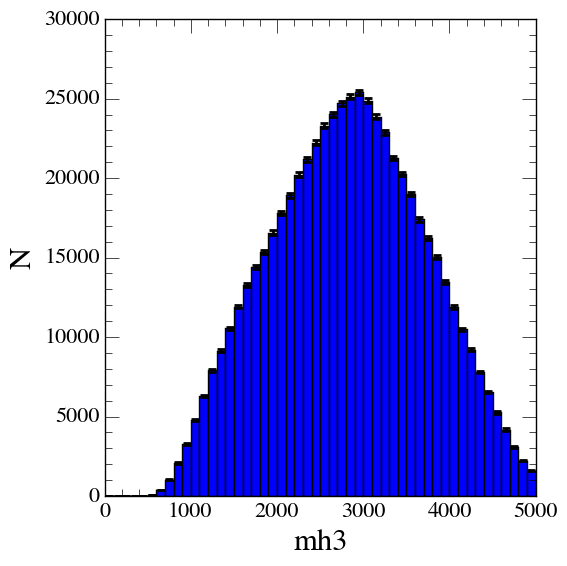

In [164]:
plot_histogram(df=df_orig_1, var='mh3', range=[0, 5000], bins=50)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a69fcf90>,
 array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   2.60000000e+01,
          4.50000000e+01,   9.60000000e+01,   1.79000000e+02,
          3.25000000e+02,   7.68000000e+02,   2.63000000e+03,
          3.23910000e+04,   2.27150000e+04,   1.70610000e+04,
          1.53700000e+04,   1.44600000e+04,   1.36940000e+04,
          1.27730000e+04,   1.22190000e+04,   1.17340000e+04,
          1.10090000e+04,   1.06200000e+04,   9.95100000e+03,
          9.63600000e+03,   9.22600000e+03,   8.99000000e+03,
          8.48600000e+03,   8.44200000e+03,   7.98400000e+03,
          7.72700000e+03,   7.64600000e+03,   7.24800000e+03,
          7.18200000e+03,   7.04400000e+03,   6.69400000e+03,
          6.48000000e+03,   6.28300000e+03,   6.21400000e+03,
          6.00500000e+03,   5.85200000e+03,   5.79100000e+03,
          5.82000000e+03,   5.44300000e+03,   5.41600000e+03,
          5.2

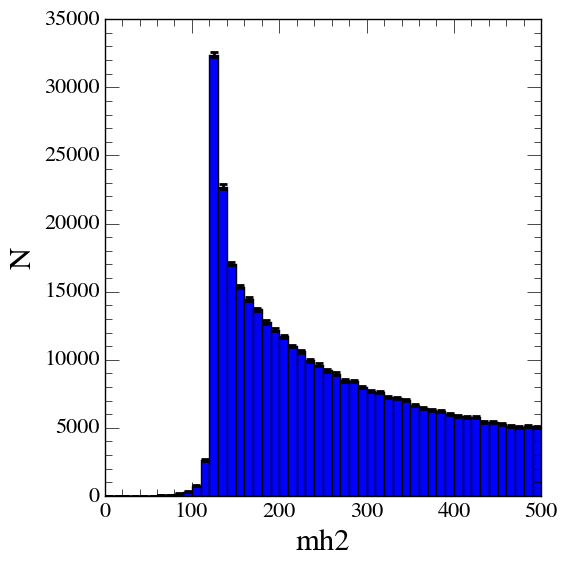

In [167]:
plot_histogram(df=df_orig_1, var='mh2', range=[0, 500], bins=50)

(<matplotlib.axes._subplots.AxesSubplot at 0x1aa53b2d0>,
 array([  2.72000000e+02,   8.26000000e+02,   1.32800000e+03,
          1.83300000e+03,   2.30900000e+03,   2.85000000e+03,
          3.12500000e+03,   3.48900000e+03,   3.63000000e+03,
          3.84700000e+03,   4.04600000e+03,   4.22700000e+03,
          4.37800000e+03,   4.59300000e+03,   4.80600000e+03,
          5.09500000e+03,   5.30300000e+03,   5.67300000e+03,
          6.06300000e+03,   6.40000000e+03,   6.96900000e+03,
          7.38900000e+03,   8.34900000e+03,   9.01700000e+03,
          1.05060000e+04,   1.22590000e+04,   1.51870000e+04,
          1.94580000e+04,   2.88700000e+04,   8.06960000e+04,
          1.50539000e+05,   1.75128000e+05,   3.03200000e+03,
          6.40000000e+01,   3.00000000e+01,   3.40000000e+01,
          2.80000000e+01,   2.20000000e+01,   1.40000000e+01,
          1.10000000e+01,   1.00000000e+01,   1.30000000e+01,
          7.00000000e+00,   5.00000000e+00,   7.00000000e+00,
          1.2

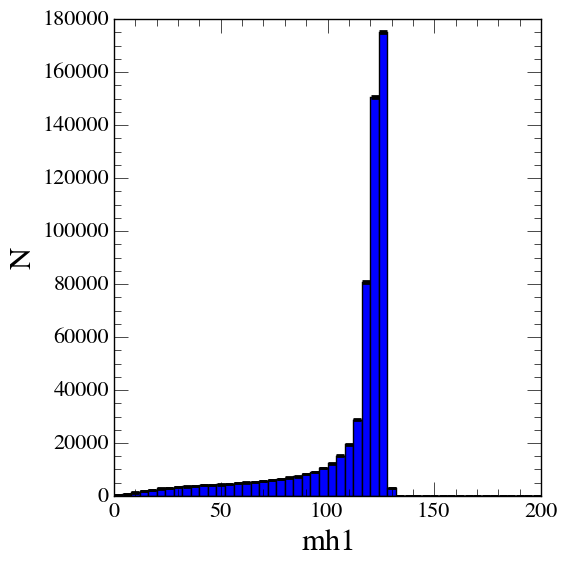

In [179]:
plot_histogram(df=df_orig_1, var='mh1', range=[0, 200], bins=50)

(<matplotlib.axes._subplots.AxesSubplot at 0x1ab1b1fd0>,
 array([  1094.,   3225.,   5045.,   6931.,   8877.,  10462.,  12143.,
         13849.,  15312.,  16772.,  18287.,  19567.,  20487.,  21805.,
         22875.,  23784.,  24722.,  25470.,  25990.,  26491.,  26931.,
         27390.,  27729.,  28090.,  28168.,  28259.,  28129.,  28385.,
         27908.,  27665.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.]),
 <a list of 30 Patch objects>)

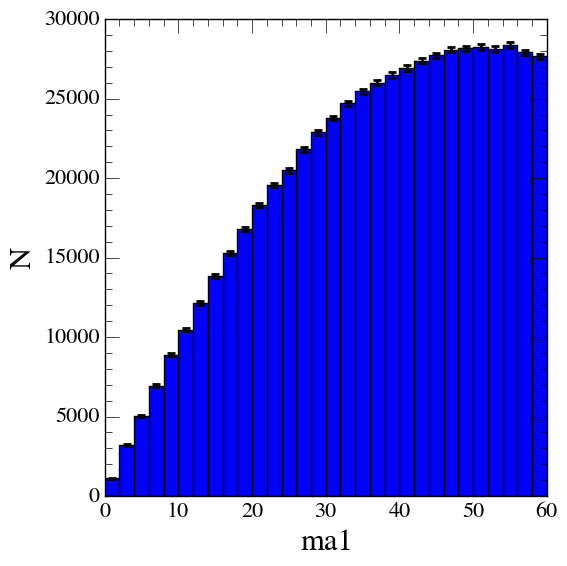

In [181]:
plot_histogram(df=df_orig_1, var='ma1', range=[0, 60], bins=30)

(<matplotlib.axes._subplots.AxesSubplot at 0x1aa750450>,
 array([  1257.,   3677.,   6103.,   8568.,  11017.,  13529.,  15922.,
         18435.,  20989.,  23240.,  25732.,  28186.,  30661.,  33074.,
         35024.,  37530.,  39455.,  40919.,  41483.,  41731.,  41502.,
         40232.,  24941.,   6890.,   1893.,   1339.,   1050.,    883.,
           733.,    570.,    487.,    439.,    369.,    329.,    273.,
           287.,    216.,    198.,    179.,    165.,    134.,    134.,
           119.,    119.,     94.,     88.,     69.,     79.,     62.,
            49.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch

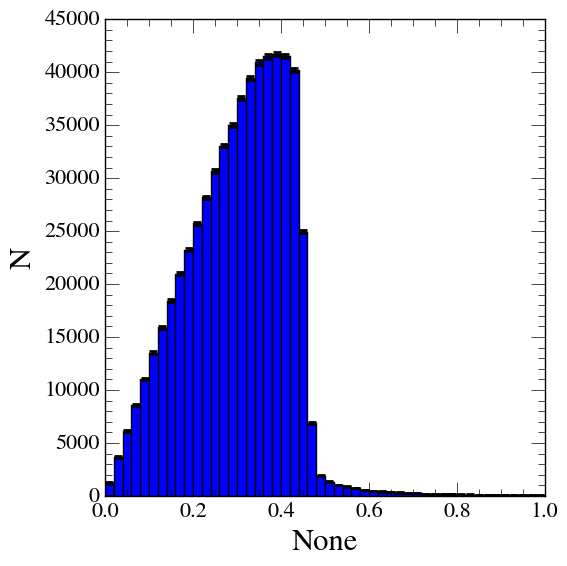

In [193]:
plot_histogram(array=(df_orig_1.ma1/df_orig_1.mneutralino1).values, range=[0, 1], bins=50)

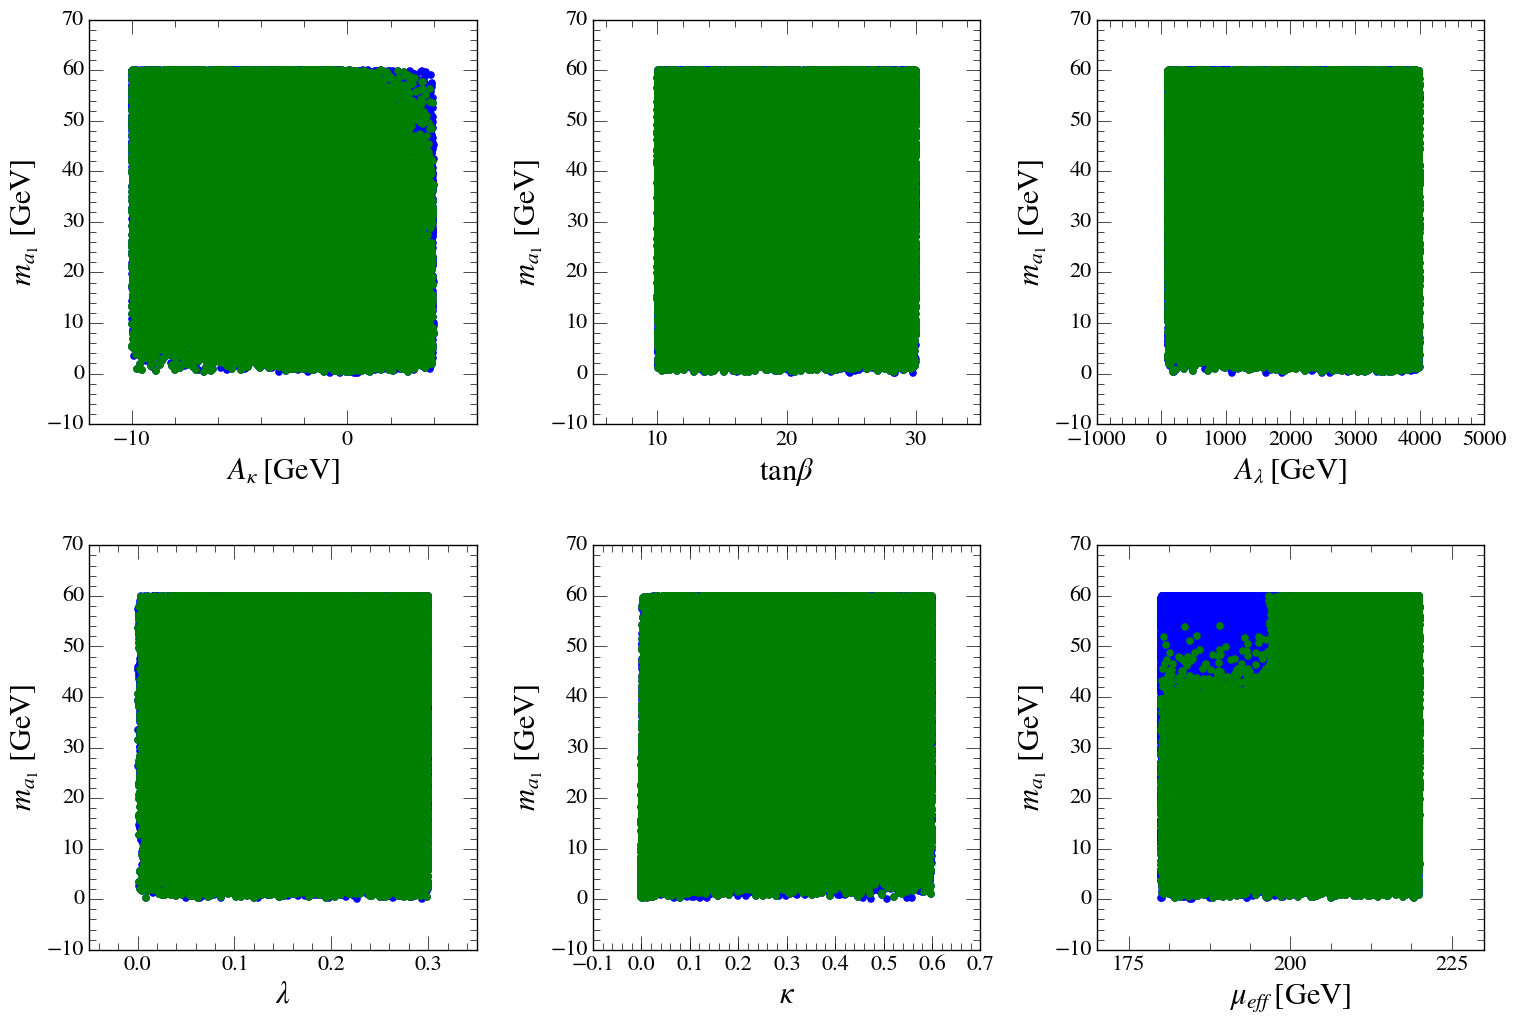

In [198]:
plot_input_params_scatters_multiple(dfs=[df_orig_1.query('pass_h125'), df_orig_1.query('pass_h125 & (not pass_relic_large | Del_a_mu<0)')], 
                                    yvar='ma1', ylabel=M_A1_STR, 
#                                  bins=[50,50], param_dict=nmssm_params_extended, 
        #                          cmap='YlOrRd', 
        #                          norm_axis=None
                                    kwargs=[dict(color='blue'), dict(color='green')]
                                   )